In [0]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
import numpy as np
from IPython.display import Image

In [0]:
#Initialise the global variables dictionary
gV = {}

#This is a global variable that corresponds to our classes
gV['predictionMap'] = ['Connor McGregor',
                 'Jon Jones',
                 'Khabib Nurmagomedov',
                'Daniel Cormier',
                'Robert Whittaker']

In [0]:
#This prepares our images for prediction or training
def prepare_image(file):
    #Set the image path as blank, essentially no path
    img_path = ''
    #Load the image from the filename and shrink to be 224x224 pixels
    img = image.load_img(img_path + file, target_size=(224, 224))
    #Convert the image to an array, this has the shape of (224,224,3)
    img_array = image.img_to_array(img)
    #Print the shape of the array
    #Add another dimension to the array
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    #Check the new shape of the array
    #Call the pre-process method from the 'mobile' model, no idea what this does
    #Actually looks like this does the following
    #1) Divide by 255
    #2) Subtract 0,5
    #3) Multiply by 2
    #I imagine it does this on every element in the array
    '''
    def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x
    '''
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

#This takes our predictions and turns them into a readable label
def decodePredictions(predictions, predictionMap):
  #Initialise dictionary to hold our labels and predictions
  decoded = {}
  #Iterate over our labels and set the probability
  for i in range(len(predictionMap)):
    decoded[predictionMap[i]] = predictions[0][i]
  return decoded

In [0]:
mobileMMA = keras.applications.mobilenet.MobileNet(weights=None, classes=5)

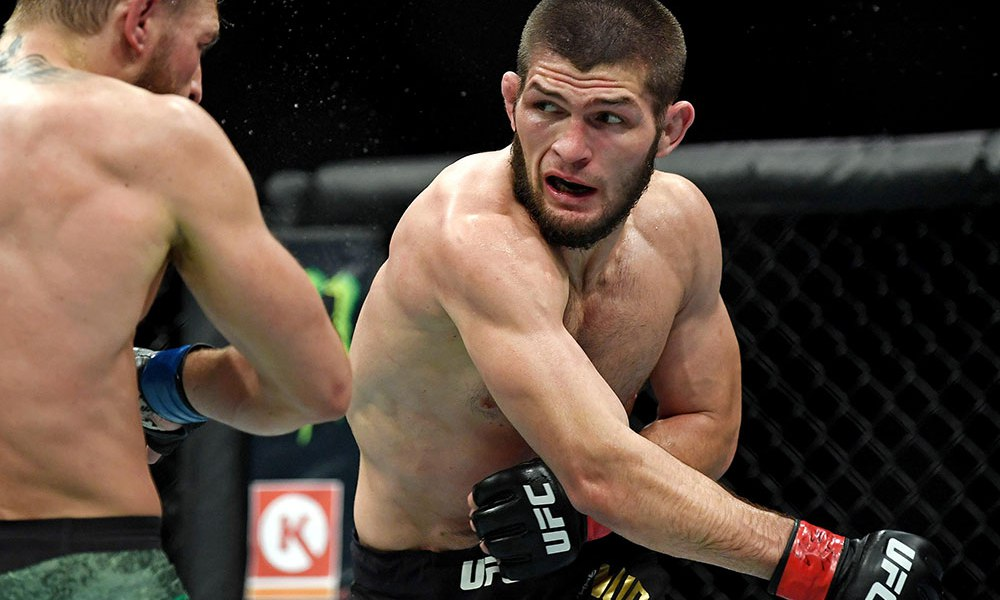

In [66]:
#Set the image that we want to predict
gV['imageFiles'] = {'Khabib Nurmagomedov': ['khabib1.jpg','khabib2.jpg','khabib3.jpg','khabib4.jpg','khabib5.jpg'],
                   'Jon Jones': ['jon1.jpg','jon2.jpeg','jon3.jpeg','jon4.jpg','jon5.jpg'],
                   'Daniel Cormier': ['daniel1.jpg','daniel2.jpg','daniel3.jpg','daniel4.jpg','daniel5.jpg'],
                    'Robert Whittaker': ['robert1.jpg','robert2.jpg','robert3.JPG','robert4.jpg','robert5.jpg'],
                    'Connor McGregor': ['connor1.jpg','connor2.jpg','connor3.jpg','connor4.jpg','connor5.jpg']
                   }
#This just previews the image
Image(filename=gV['imageFiles']['Khabib Nurmagomedov'][0])

# New Section

In [0]:
preprocessed_image = prepare_image(gV['imageFiles']['Khabib Nurmagomedov'][0])

In [68]:
#Make a prediction
predictions = mobileMMA.predict(preprocessed_image)
readablePredictions = decodePredictions(predictions, gV['predictionMap'])
print(readablePredictions)

{'Connor McGregor': 0.2, 'Jon Jones': 0.2, 'Khabib Nurmagomedov': 0.2, 'Daniel Cormier': 0.2, 'Robert Whittaker': 0.2}


In [81]:
mobileMMA.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Initialise our training images with a placeholder
trainingImages = preprocessed_image
validImages = preprocessed_image
#Initialise our labels
trainingLabels = []
validLabels = []

#Iterate over our images and create our training batch and target labels
for key in gV['imageFiles']:
  numberImages = len(gV['imageFiles'][key])
  for i in range(numberImages):  
    preprocessedImage = prepare_image(gV['imageFiles'][key][i])
    if (i+1 == numberImages):
      validImages = np.concatenate([validImages, preprocessedImage],axis=0)
      validLabels.append(gV['predictionMap'].index(key))
    else:
      trainingImages = np.concatenate([trainingImages, preprocessedImage],axis=0)
      trainingLabels.append(gV['predictionMap'].index(key))
    
#Remove our placeholder
trainingImages = trainingImages[1:,:]
validImages = validImages[1:,:]

print(trainingImages.shape, validImages.shape)

#Need a vector with labels 0 through 5. Can then use the one_hot_labels below
trainingLabels = np.asarray(trainingLabels)
validLabels = np.asarray(validLabels)

#Encode our labels
one_hot_labels_train = keras.utils.to_categorical(trainingLabels, num_classes=5)
one_hot_labels_valid = keras.utils.to_categorical(validLabels, num_classes=5)


datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(trainingImages)

mobileMMA.fit_generator(datagen.flow(trainingImages, one_hot_labels_train, batch_size=32),
                    steps_per_epoch=len(trainingImages) / 32, epochs=10)

(20, 224, 224, 3) (5, 224, 224, 3)
Epoch 1/10
1/0 [================================================] - 19s 19s/step - loss: 0.5120 - acc: 0.8100
Epoch 2/10
1/0 [================================================] - 10s 10s/step - loss: 0.8237 - acc: 0.7300
Epoch 3/10
1/0 [================================================] - 10s 10s/step - loss: 0.4511 - acc: 0.8200
Epoch 4/10
1/0 [================================================] - 10s 10s/step - loss: 0.3757 - acc: 0.8400
Epoch 5/10
1/0 [================================================] - 10s 10s/step - loss: 0.3068 - acc: 0.8700
Epoch 6/10
1/0 [================================================] - 10s 10s/step - loss: 0.2249 - acc: 0.8800
Epoch 7/10
1/0 [================================================] - 10s 10s/step - loss: 0.2490 - acc: 0.8500
Epoch 8/10
1/0 [================================================] - 10s 10s/step - loss: 0.2389 - acc: 0.9000
Epoch 9/10
1/0 [================================================] - 10s 10s/step - lo

In [82]:
score = mobileMMA.evaluate(validImages, one_hot_labels_valid, batch_size=5)
print(score)

5/5 [==============================] - 2s 489ms/step
[3.973843812942505, 0.6800000071525574]


In [0]:
#Make a prediction
preprocessed_image = prepare_image(gV['imageFiles']['Daniel Cormier'][4])
predictions = mobileMMA.predict(preprocessed_image)
readablePredictions = decodePredictions(predictions, gV['predictionMap'])